# 4. Rolling Windows

### Objectives
* Learn what a rolling window is
* Learn how to use the `rolling` method and know that it is very similar to `resample`
* Use both offset aliases and integers to specify a windows size

## Introduction
Often during time series analysis, we would like to calculate a statistic over a rolling window of time. For example, we might want to know the average of the last 3 observations.

## Visualization of Rolling Window
Here, we have a rolling window size of 3, which includes the current observation plus the preceding two. 

![][1]

[1]: images/rollingwindow3.png

Let's create the same data as a Pandas Series.

In [1]:
import pandas as pd
import numpy as np

s = pd.Series([4, 1, 12, 8, 10, 18, 2, 12])
s

0     4
1     1
2    12
3     8
4    10
5    18
6     2
7    12
dtype: int64

We now use the `rolling` method to return the same result as seen in the above visualization. The rest of this notebook explains this method.

In [2]:
s.rolling(3, min_periods=1).agg(['mean', np.size]).round(1)

,mean,size
0,4.0,1.0
1,2.5,2.0
2,5.7,3.0
3,7.0,3.0
4,10.0,3.0
5,12.0,3.0
6,10.0,3.0
7,10.7,3.0


## Get Stock Market Data Again
With our stock data, we might want to know for each day, the average closing price for the last 5 trading days. The **`rolling`** method helps accomplish this task.

First, let's read in Amazon stock data from the last 5 years.

In [3]:
url = 'https://api.iextrading.com/1.0/stock/AMZN/chart/5y'
amzn = pd.read_json(url)
amzn = amzn.set_index('date')
amzn.head()

,change,changeOverTime,changePercent,close,high,label,low,open,unadjustedVolume,volume,vwap
date,,,,,,,,,,,
2013-12-23,0.72,0.000000,0.179,402.92,405.0000,"Dec 23, 13",399.20,403.69,2661823,2661823,402.2857
2013-12-24,-3.72,-0.009233,-0.923,399.20,403.7249,"Dec 24, 13",396.37,402.52,1380373,1380373,399.4538
2013-12-26,5.19,0.003648,1.300,404.39,404.5200,"Dec 26, 13",396.81,401.79,1871590,1871590,401.8815
2013-12-27,-6.31,-0.012012,-1.560,398.08,405.6300,"Dec 27, 13",396.25,404.65,1987280,1987280,399.9122
2013-12-30,-4.71,-0.023702,-1.183,393.37,399.9200,"Dec 30, 13",392.45,399.41,2487812,2487812,394.7291


The **`rolling`** method works very similarly to **`resample`**. We pass it the offset alias of the length of our window and then aggregate as usual. It works best when you have a DatetimeIndex, otherwise you will need to specify the datetime column.

The result will always be a DataFrame (or Series) with the same number of rows as the original. The following takes the mean of the last 5 day period at each date.

In [4]:
amzn.rolling('5D').agg({'close': 'mean'}).head(10)

,close
date,
2013-12-23,402.920000
2013-12-24,401.060000
2013-12-26,402.170000
2013-12-27,401.147500
2013-12-30,398.613333
2013-12-31,396.746667
2014-01-02,396.710000
2014-01-03,396.642500
2014-01-06,396.013333


### Explanation
At each data point, the average of the **last** 5 days worth of data, which **includes the current day** are found. For instance, let's say the current day is Nov 10, 2017. Pandas will get all data back until Nov 6, 2017. It will aggregate all values found within this range. In this dataset where we have only one value per day, the maximum number of values to be aggregated in any window is 5.

This does not mean the window size is always going to contain 5 values. Most will contain less as there are no trading days on the weekend.

We can include an additional aggregation function, `np.size`, to find the number of values in each window. We should be able to use the string `'size'` but there appears to be a bug in Pandas and it's giving us an error.

In [5]:
amzn.rolling('5D').agg({'close': ['mean', np.size]}).head(10)

close     
                  mean size
date                       
2013-12-23  402.920000  1.0
2013-12-24  401.060000  2.0
2013-12-26  402.170000  3.0
2013-12-27  401.147500  4.0
2013-12-30  398.613333  3.0
2013-12-31  396.746667  3.0
2014-01-02  396.710000  3.0
2014-01-03  396.642500  4.0
2014-01-06  396.013333  3.0
2014-01-07  396.033333  3.0

## Keep window size the same with an integer
Instead of using an offset alias, you can specify a specific window size with an integer. The following will always use the last 5 values (trading days in this case), regardless of how many actual days pass, to determine an average.

When using an integer for the window, the **`rolling`** method enforces that there must be that number of values present or else a missing value will be the result. This is what you are seeing below.

In [6]:
amzn.rolling(5).agg({'close': 'mean'}).head(10)

,close
date,
2013-12-23,NaN
2013-12-24,NaN
2013-12-26,NaN
2013-12-27,NaN
2013-12-30,399.592
2013-12-31,398.766
2014-01-02,398.520
2014-01-03,396.930
2014-01-06,396.040


### Set the minimum window size
If you would like a non-missing value produced regardless of the window size, use the `min_periods` parameter to control it. Pandas defaults to a minimum period of 1 when using an offset alias.

In [7]:
amzn.rolling(5, min_periods=3).agg({'close': ['mean', np.size]}).head(10)

close     
                mean size
date                     
2013-12-23       NaN  NaN
2013-12-24       NaN  NaN
2013-12-26  402.1700  3.0
2013-12-27  401.1475  4.0
2013-12-30  399.5920  5.0
2013-12-31  398.7660  5.0
2014-01-02  398.5200  5.0
2014-01-03  396.9300  5.0
2014-01-06  396.0400  5.0
2014-01-07  396.9720  5.0

You can center the window around the current row with the `center` parameter. It will use an equal number of values before and after the current row.

In [8]:
amzn.rolling(5, min_periods=3, center=True).agg({'close': ['mean', np.size]}).head(10)

close     
                mean size
date                     
2013-12-23  402.1700  3.0
2013-12-24  401.1475  4.0
2013-12-26  399.5920  5.0
2013-12-27  398.7660  5.0
2013-12-30  398.5200  5.0
2013-12-31  396.9300  5.0
2014-01-02  396.0400  5.0
2014-01-03  396.9720  5.0
2014-01-06  397.5980  5.0
2014-01-07  398.2060  5.0

# Plotting
Let's find the trailing 50-day min, mean, and max of the closing price. Here, we will require at least 50 trading days worth of data.

In [9]:
rolling_stats = amzn.rolling(50).agg({'close': ['min', 'mean', 'max']})
rolling_stats.head()

close         
             min mean max
date                     
2013-12-23   NaN  NaN NaN
2013-12-24   NaN  NaN NaN
2013-12-26   NaN  NaN NaN
2013-12-27   NaN  NaN NaN
2013-12-30   NaN  NaN NaN

Remove all rows that did not have 50 preceding days worth of data.

In [10]:
rolling_stats = rolling_stats.dropna()
rolling_stats.head()

close                  
               min      mean     max
date                                
2014-03-06  346.15  377.7898  407.05
2014-03-07  346.15  377.1726  407.05
2014-03-10  346.15  376.5992  407.05
2014-03-11  346.15  375.8878  407.05
2014-03-12  346.15  375.3390  407.05

Rename columns:

In [11]:
rolling_stats.columns = ['Min', 'Mean', 'Max']

Import matplotlib and choose a nice style:

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

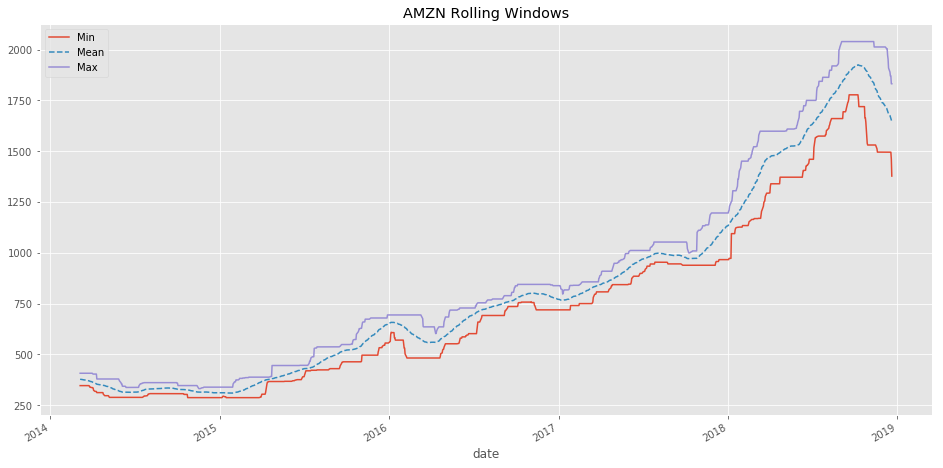

In [13]:
rolling_stats.plot(figsize=(16, 8), style=['-', '--', '-'], title='AMZN Rolling Windows')

## Resampling and Rolling Windows with a  Series - A bit easier
Resampling and rolling window calculations can be done on Series that have DatetimeIndexes. The syntax becomes a bit easier since you don't have to specify an aggregating column. If you are only applying one aggregating function to the group, you can call it directly as method. With Series **`s`**, the syntax will look like this:

```
>>> s.resample('5D').sum()
```

We select the closing price as a Series and proceed to call both the **`resample`** and **`rolling`** methods on it.

In [14]:
close = amzn['close']
close.head()

date
2013-12-23    402.92
2013-12-24    399.20
2013-12-26    404.39
2013-12-27    398.08
2013-12-30    393.37
Name: close, dtype: float64

Find the mean over a two month period.

In [15]:
close.resample('2M').mean().head()

date
2013-12-31    399.458333
2014-02-28    375.613250
2014-04-30    342.135714
2014-06-30    313.763452
2014-08-31    333.772000
Name: close, dtype: float64

Find the rolling mean of the previous 5 trading days.

In [16]:
close.rolling(5).mean().head(10)

date
2013-12-23        NaN
2013-12-24        NaN
2013-12-26        NaN
2013-12-27        NaN
2013-12-30    399.592
2013-12-31    398.766
2014-01-02    398.520
2014-01-03    396.930
2014-01-06    396.040
2014-01-07    396.972
Name: close, dtype: float64

Multiple aggregation functions.

In [17]:
close.resample('2M').agg(['min', 'mean', 'max', np.size]).head()

,min,mean,max,size
date,,,,
2013-12-31,393.37,399.458333,404.39,6.0
2014-02-28,346.15,375.613250,407.05,40.0
2014-04-30,296.58,342.135714,378.77,42.0
2014-06-30,288.32,313.763452,335.20,42.0
2014-08-31,307.06,333.772000,360.84,43.0


# Exercises

## Problem 1
<span  style="color:green; font-size:16px">Use the employee dataset for this problem. Attempt to take a rolling average on salary using a 30 day time span on hire date. Does the error message make sense?</span>

In [81]:
import pandas as pd
import numpy as np

In [87]:
emp = pd.read_csv('../data/employee.csv', parse_dates=['hire_date'])

In [83]:
emp.rolling('30D', on='hire_date')

ValueError: hire_date must be monotonic

## Problem 2
<span  style="color:green; font-size:16px">Set hire date as the index and then select the salary column as a Series. Sort the Series by date and drop the missing values. Now select a subset that only has hire dates from 1990 onwards. Then find a 1,000 day rolling average. Finally make a call to the `plot` method. Make sure you inline matplotlib if you did not do it earlier.</span>

In [ ]:
%matplotlib inline

In [88]:
emp = emp.set_index('hire_date')

In [89]:
emp.head()

,title,dept,salary,race,gender
hire_date,,,,,
2015-02-03,POLICE OFFICER,Houston Police Department-HPD,45279.0,White,Male
1982-02-08,ENGINEER/OPERATOR,Houston Fire Department (HFD),63166.0,White,Male
1984-11-26,SENIOR POLICE OFFICER,Houston Police Department-HPD,66614.0,Black,Male
2012-03-26,ENGINEER,Public Works & Engineering-PWE,71680.0,Asian,Male
2013-11-04,CARPENTER,Houston Airport System (HAS),42390.0,White,Male


In [94]:
salary = emp['salary']
salary = salary.sort_index(ascending=True).dropna()

In [95]:
salary.head()

hire_date
1958-12-29     81239.0
1968-11-25     89590.0
1972-11-13     66614.0
1977-07-20    163228.0
1978-03-13     81239.0
Name: salary, dtype: float64

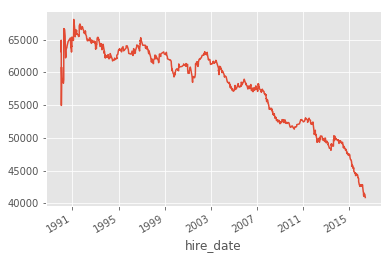

In [96]:
salary['1990':].rolling('1000D').mean().plot()

## Problem 3
<span  style="color:green; font-size:16px">Read in the energy consumption dataset. Select just the residential source and plot a 12 month trailing rolling mean of the energy.</span>

In [105]:
energy = pd.read_csv('../data/energy_consumption.csv', parse_dates=['date'], index_col='date')
energy.head()

,source,energy (btu)
date,,
1973-01-01,residential,1932.187
1973-02-01,residential,1687.255
1973-03-01,residential,1497.067
1973-04-01,residential,1177.661
1973-05-01,residential,1015.008


In [106]:
filt = energy['source']=='resindential'
res_energy = energy.loc[filt, 'energy (btu)']
res_energy.head()

Series([], Name: energy (btu), dtype: float64)